## Data Prep

**Import necessary modules and the ASOS/SNOTEL dataframes**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dtb
import os
from glob import glob
import datetime as dt
import seaborn as sns
pd.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.5.final.0
python-bits: 32
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8
LOCALE: None.None

pandas: 0.24.0
pytest: None
pip: 18.1
setuptools: 39.0.1
Cython: None
numpy: 1.14.3
scipy: 1.1.0
pyarrow: None
xarray: None
IPython: 6.4.0
sphinx: None
patsy: 0.5.1
dateutil: 2.7.3
pytz: 2018.4
blosc: None
bottleneck: None
tables: None
numexpr: None
feather: None
matplotlib: 2.2.2
openpyxl: None
xlrd: None
xlwt: None
xlsxwriter: None
lxml.etree: 4.2.5
bs4: None
html5lib: 1.0.1
sqlalchemy: None
pymysql: None
psycopg2: None
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None
gcsfs: None


In [2]:
data = [pd.read_csv('asos_snotel_UA_12hr_df.dat', parse_dates = True, index_col = 'Date_Time')]
asos_snotel_UA_df = pd.concat(data)
#asos_snotel_UA_df['LXV_WindSpeed_m/s']

#asos_snotel_UA_df.rename(columns={'LXV_WindSpeed_m/s': 'LXV_WindSpeed_mps'}, inplace=True)

asos_snotel_UA_df.astype('float16')
pd.set_option('display.expand_frame_repr', True)


print(asos_snotel_UA_df.keys())




#delete empty columns as they mess up loops
#del asos_snotel_UA_df['CMtn_6hr_Precipitation_mm']            #empty column


Index(['CMtnSNTL_Temp_degC', 'CMtnSNTL_SnowDepth_in', 'CMtn_Temperature_degC',
       'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps',
       'CMtn_CloudCover_oktas', 'CMtn_1hr_Precipitation_mm',
       'LXV_Temperature_degC', 'LXV_Dewpoint_degC',
       ...
       'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc',
       'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts',
       'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc',
       'KGJT_d250_200_drct', 'KGJT_d250_200_speed_kts'],
      dtype='object', length=163)


In [3]:
all_yrs = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2018')
train_yrs = ((asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-01-2014')) | ((asos_snotel_UA_df.index >= '01-01-2015') & (asos_snotel_UA_df.index < '01-01-2018'))
test_yrs = (asos_snotel_UA_df.index >= '01-01-2014') & (asos_snotel_UA_df.index < '01-01-2015')

test = (asos_snotel_UA_df.index >= '01-01-2006') & (asos_snotel_UA_df.index < '01-02-2006')
print(asos_snotel_UA_df['KGJT_d300_200_height_m'][test])

Date_Time
2006-01-01 00:00:00+00:00   -2630.0
2006-01-01 12:00:00+00:00   -2700.0
Name: KGJT_d300_200_height_m, dtype: float64


It is important to keep in mind that 'CMtnSNTL_12hr_SNWD_in contains snow depth info taken at the start of the respective 12hr period timestamp.  The snowfall calculated also gives the snowfall that fell in the 12hrs after the timestamp.  The OLS model will utilize hourly meteorological measurements at exactly 00:00 and 12:00 hours to predict the amount of snow which will fall in the next 12 hour period.  For example, the 00:00 meteorological measurements will be used to predict the snow which fell between 00:00 and 12:00.

***
# OLS Analysis of meteorological variables and snowfall (Training Dataset: 2007-2016 only)

**We will first utilize just the Copper Mountain surface level variables and run the model explicitly to generate statistics.  This will give snowfall predictive capability of individual meteorological variables (Dewpoint, SNOTEL Temperature, Temperature, Wind Speed, Cloud Cover, Wind Direction, 6hr Pressure change, and Pressure) using an OLS model and the 2008-2017 training dataset. The resulting values will also be used to verify some code which performs same analysis, but with a loop.  This code will then be fed all upper air and surface level variables to determine best combination of variables in the OLS model.**


In [4]:
#Import statsmodel

import statsmodels.api as sm
#import statsmodel
from statsmodels.formula.api import ols

### Single Variable OLS (CMtn Surface Variables)


#### Single Variable Summary
**Adjusted R:**  
OLS_CMtn_Dewpoint: 0.007  
OLS_CMtnSNTL_Temp:  -0.002 
OLS_CMtn_Temperature: -0.005  
OLS_CMtn_WindSpeed:  0.017  
OLS_CMtn_CloudCover:  0.000  
OLS_CMtn_WindDirection:  -0.004  
OLS_LXV_6hr_delta_Pressure:   0.004  
OLS_LXV_Pressure:    -0.003  

**Prob (F-statistic):**  
OLS_CMtn_Dewpoint: 0.139  
OLS_CMtnSNTL_Temp: 0.483  
OLS_CMtn_Temperature:  0.708  
OLS_CMtn_WindSpeed:  0.0466  
OLS_CMtn_CloudCover: 0.316 
OLS_CMtn_WindDirection:   0.614  
OLS_LXV_6hr_delta_Pressure:  0.155  
OLS_LXV_Pressure:   0.550 
  
From this, we can glean that Dewpoint alone likely has the best fit as the adjusted R squared is the highest.  The F statistics such signficant correlations (at 5% confident interval) for only  Dewpoint and Pressure).

## Determine which columns to use in OLS model.   
### Only going to to keep those data columns which have a matching hour to at least 67% of the snowfall measurements

In [5]:
variables = ['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'CMtn_CloudCover_oktas', \
 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps',  'LXV_CloudCover_oktas', 'LXV_12hr_delta_Pressure_hp', \
 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_speed_kts', \
 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_speed_kts', \
 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_speed_kts', \
 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_speed_kts', \
 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_speed_kts', \
 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_speed_kts', \
 'KGJT_850mb_height_m', 'KGJT_850mb_tmpc', 'KGJT_850mb_dwpc', 'KGJT_850mb_speed_kts', \
 'KGJT_d850_700_height_m', 'KGJT_d850_700_tmpc', 'KGJT_d850_700_dwpc', 'KGJT_d850_700_speed_kts', \
 'KGJT_d850_500_height_m', 'KGJT_d850_500_tmpc', 'KGJT_d850_500_dwpc', 'KGJT_d850_500_speed_kts', \
 'KGJT_d850_400_height_m', 'KGJT_d850_400_tmpc', 'KGJT_d850_400_dwpc', 'KGJT_d850_400_speed_kts', \
 'KGJT_d850_300_height_m', 'KGJT_d850_300_tmpc', 'KGJT_d850_300_dwpc', 'KGJT_d850_300_speed_kts', \
 'KGJT_d850_250_height_m', 'KGJT_d850_250_tmpc', 'KGJT_d850_250_dwpc', 'KGJT_d850_250_speed_kts', \
 'KGJT_d850_200_height_m', 'KGJT_d850_200_tmpc', 'KGJT_d850_200_dwpc', 'KGJT_d850_200_speed_kts',\
 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_speed_kts', \
 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_speed_kts', \
 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_speed_kts', \
 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_speed_kts', \
 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_speed_kts', \
 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_speed_kts', \
 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_speed_kts', \
 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_speed_kts', \
 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_speed_kts', \
 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_speed_kts', \
 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_speed_kts', \
 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_speed_kts', \
 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_speed_kts', \
 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_speed_kts', \
 'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_speed_kts']

good_vars = []
bad_vars = []
for var in variables:
    idx = np.isfinite(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']) & np.isfinite(asos_snotel_UA_df[all_yrs][var])
 #   total_poss = len(asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=0])
    
    total_poss = asos_snotel_UA_df[all_yrs]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'].count()   #counts only non missing values
    total_avail =len(asos_snotel_UA_df[all_yrs][idx]) 
    
    if total_avail/total_poss >= 0.67: 
        good_vars.append(var)
    else:
        bad_vars.append(var)
        


        
print('Variables with >= 67% data match to snowfall: ')
print(good_vars)
print('Variables with < 67% data match to snowfall: ')
print(bad_vars)
    



Variables with >= 67% data match to snowfall: 
['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d70

In [6]:
good_vars_snf =[]
filtered_asos_snotel_UA_df = pd.DataFrame()


#df_sfc = asos_snotel_UA_df[['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', \
#                           'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp','CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']].copy()
#
#df = asos_snotel_UA_df[df = asos_snotel_UA_df[['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindDirection_deg', 'CMtn_WindSpeed_mps', \
#                        'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_WindDirection_deg', 'LXV_12hr_delta_Pressure_hp', \
#                        'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_drct', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', \
#                        'KGJT_250mb_dwpc', 'KGJT_250mb_drct', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_drct', \
#                        'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_drct', 'KGJT_400mb_speed_kts', \
#                        'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_drct', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', \
#                        'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_drct', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', \
#                        'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_drct', 'KGJT_d700_500_speed_kts', 'KGJT_d700_400_height_m', 'KGJT_d700_400_tmpc', 'KGJT_d700_400_dwpc', 'KGJT_d700_400_drct', 'KGJT_d700_400_speed_kts', 'KGJT_d700_300_height_m', 'KGJT_d700_300_tmpc', 'KGJT_d700_300_dwpc', 'KGJT_d700_300_drct', 'KGJT_d700_300_speed_kts', 'KGJT_d700_250_height_m', 'KGJT_d700_250_tmpc', 'KGJT_d700_250_dwpc', 'KGJT_d700_250_drct', 'KGJT_d700_250_speed_kts', 'KGJT_d700_200_height_m', 'KGJT_d700_200_tmpc', 'KGJT_d700_200_dwpc', 'KGJT_d700_200_drct', 'KGJT_d700_200_speed_kts', 'KGJT_d500_400_height_m', 'KGJT_d500_400_tmpc', 'KGJT_d500_400_dwpc', 'KGJT_d500_400_drct', 'KGJT_d500_400_speed_kts', 'KGJT_d500_300_height_m', 'KGJT_d500_300_tmpc', 'KGJT_d500_300_dwpc', 'KGJT_d500_300_drct', 'KGJT_d500_300_speed_kts', 'KGJT_d500_250_height_m', 'KGJT_d500_250_tmpc', 'KGJT_d500_250_dwpc', 'KGJT_d500_250_drct', 'KGJT_d500_250_speed_kts', 'KGJT_d500_200_height_m', 'KGJT_d500_200_tmpc', 'KGJT_d500_200_dwpc', 'KGJT_d500_200_drct', 'KGJT_d500_200_speed_kts', 'KGJT_d400_300_height_m', 'KGJT_d400_300_tmpc', 'KGJT_d400_300_dwpc', 'KGJT_d400_300_drct', 'KGJT_d400_300_speed_kts', 'KGJT_d400_250_height_m', 'KGJT_d400_250_tmpc', 'KGJT_d400_250_dwpc', 'KGJT_d400_250_drct', 'KGJT_d400_250_speed_kts', 'KGJT_d400_200_height_m', 'KGJT_d400_200_tmpc', 'KGJT_d400_200_dwpc', 'KGJT_d400_200_drct', 'KGJT_d400_200_speed_kts', 'KGJT_d300_250_height_m', 'KGJT_d300_250_tmpc', 'KGJT_d300_250_dwpc', 'KGJT_d300_250_drct', 'KGJT_d300_250_speed_kts', 'KGJT_d300_200_height_m', 'KGJT_d300_200_tmpc', 'KGJT_d300_200_dwpc', 'KGJT_d300_200_drct', 'KGJT_d300_200_speed_kts', \
#                        'KGJT_d250_200_height_m', 'KGJT_d250_200_tmpc', 'KGJT_d250_200_dwpc', 'KGJT_d250_200_drct', \
#                         'KGJT_d250_200_speed_kts','CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']].copy()

good_vars_snf = good_vars + ['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']
print(good_vars_snf )
filtered_asos_snotel_UA_df=  asos_snotel_UA_df[good_vars_snf].copy()
test_train_df = asos_snotel_UA_df[good_vars_snf].dropna()

print(test_train_df)

['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_speed_kts', 'KGJT_d

In [7]:
import statistics as sts
all_yrs_tt = (test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2018')
train_yrs_tt=  ((test_train_df.index >= '01-01-2006') & (test_train_df.index < '01-01-2014')) | ((test_train_df.index >= '01-01-2015') & (test_train_df.index < '01-01-2018'))
test_yrs_tt = (test_train_df.index >= '01-01-2014') & (test_train_df.index < '01-01-2015')



### Now run OLS model with the chosen variables ##

In [8]:
from collections import OrderedDict

variables = good_vars
variables_org = variables
print(variables)

print('******')
adjRs = []
newRs = []
dup_var = []
max_vars = []
f_pvalues = []

while variables != []:
  #print(variables)
  for var in variables:
        
    #print(variables)
    max_var = max(variables, key = lambda v: ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + v, test_train_df[train_yrs_tt]).fit().rsquared_adj)    #this finds OLS model run with highest adj R squared
    OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + max_var, test_train_df[train_yrs_tt]).fit()
    print(max_var)
    print(OLS.rsquared_adj)
    
    #Create lists of statistics for each combination of variables modeld
    adjRs.append(OLS.rsquared_adj)
    f_pvalues.append(OLS.f_pvalue)
    max_vars.append(max_var)

    add_max_var = '+ '+ max_var
    
    variables = [s + add_max_var for s in variables_org]
    
    #The above for loop naturally will create a duplicate variable, which should be removed
    for v in variables_org: 
      dup_var = []
      dup_var = [var for var in variables if var.count(v)>1]
      if dup_var!=[]:
            for dup in dup_var: variables.remove(dup)

#combine the modeled variable sequences with respective stats  
stats = list(zip(adjRs, f_pvalues))    # create list of tuples
dictionary = OrderedDict(zip(max_vars, stats))
#dictionary_adjRs = OrderedDict(zip(max_vars, f_pvalues))
print(adjRs)
print(max_vars)
print(f_pvalues)
print(dictionary)



['CMtnSNTL_Temp_degC', 'CMtn_Temperature_degC', 'CMtn_Dewpoint_degC', 'CMtn_WindSpeed_mps', 'LXV_Temperature_degC', 'LXV_Dewpoint_degC', 'LXV_Pressure_hp', 'LXV_WindSpeed_mps', 'LXV_12hr_delta_Pressure_hp', 'KGJT_200mb_height_m', 'KGJT_200mb_tmpc', 'KGJT_200mb_dwpc', 'KGJT_200mb_speed_kts', 'KGJT_250mb_height_m', 'KGJT_250mb_tmpc', 'KGJT_250mb_dwpc', 'KGJT_250mb_speed_kts', 'KGJT_300mb_height_m', 'KGJT_300mb_tmpc', 'KGJT_300mb_dwpc', 'KGJT_300mb_speed_kts', 'KGJT_400mb_height_m', 'KGJT_400mb_tmpc', 'KGJT_400mb_dwpc', 'KGJT_400mb_speed_kts', 'KGJT_500mb_height_m', 'KGJT_500mb_tmpc', 'KGJT_500mb_dwpc', 'KGJT_500mb_speed_kts', 'KGJT_700mb_height_m', 'KGJT_700mb_tmpc', 'KGJT_700mb_dwpc', 'KGJT_700mb_speed_kts', 'KGJT_850mb_height_m', 'KGJT_d850_700_height_m', 'KGJT_d850_500_height_m', 'KGJT_d850_400_height_m', 'KGJT_d850_300_height_m', 'KGJT_d850_250_height_m', 'KGJT_d850_200_height_m', 'KGJT_d700_500_height_m', 'KGJT_d700_500_tmpc', 'KGJT_d700_500_dwpc', 'KGJT_d700_500_speed_kts', 'KGJT_d

KGJT_d500_250_tmpc+ KGJT_d250_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_500mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ LXV_Dewpoint_degC+ KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC
0.1229693675472493
LXV_Pressure_hp+ KGJT_d500_250_tmpc+ KGJT_d250_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_500mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ LXV_Dewpoint_degC+ KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwp

KGJT_d500_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_700mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_400_dwpc+ KGJT_700mb_dwpc+ KGJT_500mb_height_m+ KGJT_200mb_height_m+ KGJT_250mb_height_m+ LXV_Pressure_hp+ KGJT_d500_250_tmpc+ KGJT_d250_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_500mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ LXV_Dewpoint_degC+ KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC
0.10705311666542883
KGJT_d850_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_700mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_400_dwpc+ KGJT_700mb_dwpc+ K

KGJT_850mb_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_700mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_400_dwpc+ KGJT_700mb_dwpc+ KGJT_500mb_height_m+ KGJT_200mb_height_m+ KGJT_250mb_height_m+ LXV_Pressure_hp+ KGJT_d500_250_tmpc+ KGJT_d250_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_500mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ LXV_Dewpoint_degC+ KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC
0.09069106532093862
KG

KGJT_d850_250_height_m+ KGJT_d500_400_height_m+ KGJT_d500_300_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_300mb_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_850mb_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_700mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_400_dwpc+ KGJT_700mb_dwpc+ KGJT_500mb_height_m+ KGJT_200mb_height_m+ KGJT_250mb_height_m+ LXV_Pressure_hp+ KGJT_d500_250_tmpc+ KGJT_d250_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_500mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ LXV_Dewpoint_degC+ KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300

KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_250_height_m+ KGJT_d400_250_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_400_height_m+ KGJT_d500_300_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_300mb_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_850mb_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_700mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_400_dwpc+ KGJT_700mb_dwpc+ KGJT_500mb_height_m+ KGJT_200mb_height_m+ KGJT_250mb_height_m+ LXV_Pressure_hp+ KGJT_d500_250_tmpc+ KGJT_d250_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_500mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc+ C

KGJT_d500_200_speed_kts+ KGJT_d700_200_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_250_height_m+ KGJT_d400_250_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_400_height_m+ KGJT_d500_300_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_300mb_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_850mb_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_700mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_400_dwpc+ KGJT_700mb_dwpc+ KGJT_500mb_height_m+ KGJT_200mb_height_m+ KGJT_250mb_height_m+ LXV_Pressure_hp+ KGJT_d500_250_tmpc+ KGJT_d250_200_tmpc+ KGJT_250mb_tmpc+ KGJT

KGJT_500mb_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_500_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_200_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_250_height_m+ KGJT_d400_250_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_400_height_m+ KGJT_d500_300_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_300mb_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_850mb_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_700mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_400_dwpc+ KGJT_700mb_dwpc+ KGJT_500mb_height_m

KGJT_d700_250_height_m+ KGJT_d700_400_height_m+ KGJT_700mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_dwpc+ KGJT_500mb_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_500_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_200_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_250_height_m+ KGJT_d400_250_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_400_height_m+ KGJT_d500_300_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_300mb_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_850mb_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_250

KGJT_200mb_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d850_700_height_m+ KGJT_d700_500_height_m+ KGJT_d700_250_height_m+ KGJT_d700_400_height_m+ KGJT_700mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_dwpc+ KGJT_500mb_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_500_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_200_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_250_height_m+ KGJT_d400_250_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_400_height_m+ KGJT_d500_300_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_300mb_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_850mb_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT

KGJT_300mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d850_700_height_m+ KGJT_d700_500_height_m+ KGJT_d700_250_height_m+ KGJT_d700_400_height_m+ KGJT_700mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_dwpc+ KGJT_500mb_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_500_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_200_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_250_height_m+ KGJT_d400_250_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_400_height_m+ KGJT_d500_300_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_300mb_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_850mb_height_m+ LXV_12hr_delta_Pressure_hp+ KG

KGJT_d700_400_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d850_700_height_m+ KGJT_d700_500_height_m+ KGJT_d700_250_height_m+ KGJT_d700_400_height_m+ KGJT_700mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_dwpc+ KGJT_500mb_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_500_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_200_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_250_height_m+ KGJT_d400_250_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_400_height_m+ KGJT_d500_300_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_heigh

KGJT_d400_300_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d850_700_height_m+ KGJT_d700_500_height_m+ KGJT_d700_250_height_m+ KGJT_d700_400_height_m+ KGJT_700mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_dwpc+ KGJT_500mb_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_500_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_200_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_250_height_m+ KGJT_d400_250_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_heig

**Create plot of adjusted R squared**

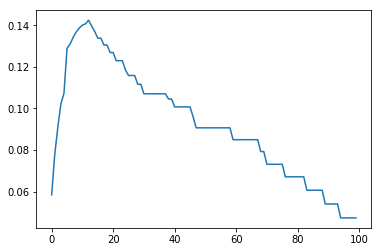

In [9]:
plt.plot(adjRs)

**Create plot of probabilities associated with the F statistic**

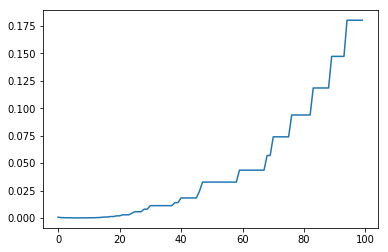

In [10]:
plt.plot(f_pvalues)

**Print adjusted R and F stat probabilities in order**

In [11]:


for c in dictionary:
    #print(str(dictionary.keys().index(c))+"{country}: {capital}".format(country=c, capital=dictionary[c])+"\n")
        print(str(list(dictionary.keys()).index(c))+ " {key} \n Adjusted R: {adjR}  Fstat(prob): {f_pvalue}".format(key=c, adjR=dictionary[c][0], f_pvalue = dictionary[c][1])+"\n")
        OLS = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + c, test_train_df[train_yrs_tt]).fit()



0 CMtn_Dewpoint_degC 
 Adjusted R: 0.05846074932092893  Fstat(prob): 0.0007164770060356683

1 KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 
 Adjusted R: 0.07780901800257956  Fstat(prob): 0.0003351213135640897

2 KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 
 Adjusted R: 0.09095135913334995  Fstat(prob): 0.0002226411180402769

3 KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 
 Adjusted R: 0.10216776970759212  Fstat(prob): 0.000158460807364647

4 LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 
 Adjusted R: 0.10728648513098205  Fstat(prob): 0.00017933620138488418

5 KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 
 Adjusted R: 0.12888653809262074  Fstat(prob): 4.776355604745994e-05

6 CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 
 Adjusted R: 0.13103

25 KGJT_250mb_height_m+ LXV_Pressure_hp+ KGJT_d500_250_tmpc+ KGJT_d250_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_500mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ LXV_Dewpoint_degC+ KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 
 Adjusted R: 0.11585197211467713  Fstat(prob): 0.005679644850858225

26 KGJT_200mb_height_m+ KGJT_250mb_height_m+ LXV_Pressure_hp+ KGJT_d500_250_tmpc+ KGJT_d250_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_500mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ LXV_Dewpoint_degC+ KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_

37 KGJT_d500_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_700mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_400_dwpc+ KGJT_700mb_dwpc+ KGJT_500mb_height_m+ KGJT_200mb_height_m+ KGJT_250mb_height_m+ LXV_Pressure_hp+ KGJT_d500_250_tmpc+ KGJT_d250_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_500mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ LXV_Dewpoint_degC+ KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 
 Adjusted R: 0.10705311666542883  Fstat(prob): 0.011215999506486104

38 KGJT_d850_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_700mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_500_tmpc+ KG

46 LXV_12hr_delta_Pressure_hp+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_700mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_400_dwpc+ KGJT_700mb_dwpc+ KGJT_500mb_height_m+ KGJT_200mb_height_m+ KGJT_250mb_height_m+ LXV_Pressure_hp+ KGJT_d500_250_tmpc+ KGJT_d250_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_500mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ LXV_Dewpoint_degC+ KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 
 Adjusted R: 0.09602736859954264  Fstat

54 KGJT_d500_400_height_m+ KGJT_d500_300_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_300mb_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_850mb_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_700mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_400_dwpc+ KGJT_700mb_dwpc+ KGJT_500mb_height_m+ KGJT_200mb_height_m+ KGJT_250mb_height_m+ LXV_Pressure_hp+ KGJT_d500_250_tmpc+ KGJT_d250_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_500mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc+ CMtnSNTL_Temp_degC+ LXV_Dewpoint_degC+ KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSp

62 KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_250_height_m+ KGJT_d400_250_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_400_height_m+ KGJT_d500_300_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_300mb_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_850mb_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_700mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_400_dwpc+ KGJT_700mb_dwpc+ KGJT_500mb_height_m+ KGJT_200mb_height_m+ KGJT_250mb_height_m+ LXV_Pressure_hp+ KGJT_d500_250_tmpc+ KGJT_d250_200_tmpc+ KGJT_250mb_tmpc+ KGJT_d500_200_tmpc+ KGJT_500mb_tmpc+ KGJT_d250_200_height_m+ KGJT_d500_200_height_m+ KGJT_d300_250_dwpc+ KGJT_d300_200_dwpc

68 KGJT_d500_200_speed_kts+ KGJT_d700_200_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_250_height_m+ KGJT_d400_250_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_400_height_m+ KGJT_d500_300_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_300mb_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_850mb_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_700mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_400_dwpc+ KGJT_700mb_dwpc+ KGJT_500mb_height_m+ KGJT_200mb_height_m+ KGJT_250mb_height_m+ LXV_Pressure_hp+ KGJT_d500_250_tmpc+ KGJT_d250_200_tmpc+ KGJT_250mb_tmpc+ K

74 KGJT_500mb_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_500_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_200_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_250_height_m+ KGJT_d400_250_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_400_height_m+ KGJT_d500_300_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_300mb_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_850mb_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_250_tmpc+ KGJT_700mb_tmpc+ KGJT_400mb_tmpc+ KGJT_d700_500_tmpc+ KGJT_d700_200_tmpc+ KGJT_d700_400_dwpc+ KGJT_700mb_dwpc+ KGJT_500mb_heigh

80 KGJT_d700_250_height_m+ KGJT_d700_400_height_m+ KGJT_700mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_dwpc+ KGJT_500mb_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_500_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_200_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_250_height_m+ KGJT_d400_250_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_400_height_m+ KGJT_d500_300_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_300mb_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_850mb_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc+ KGJT_d300_250_tmpc+ KGJT_d850_300_height_m+ KGJT_d850_400_height_m+ KGJT_d500_400_tmpc+ KGJT_d400_250_tmpc+ KGJT_d400_200_tmpc+ KGJT_d700_


86 KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d850_700_height_m+ KGJT_d700_500_height_m+ KGJT_d700_250_height_m+ KGJT_d700_400_height_m+ KGJT_700mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_dwpc+ KGJT_500mb_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_500_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_200_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_250_height_m+ KGJT_d400_250_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_400_height_m+ KGJT_d500_300_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_300mb_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_850mb_height_m+ LXV_12hr_delta_Pressure_hp+ KGJT_d500_300_tmpc+ KGJT_300mb_tmpc+ KGJT_d700_300_tmpc+ KGJT_d300_200_tmpc+ KGJT_d400_300_tmpc


91 KGJT_d300_250_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d850_700_height_m+ KGJT_d700_500_height_m+ KGJT_d700_250_height_m+ KGJT_d700_400_height_m+ KGJT_700mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_dwpc+ KGJT_500mb_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_500_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_200_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_250_height_m+ KGJT_d400_250_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_400_height_m+ KGJT_d500_300_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_height_m+ KGJT_300mb_height_m+ KGJT_d850_500_height_m+ KGJT_d400_200_height_m+ KGJT_850mb_height_m+ L


95 KGJT_d700_400_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d850_700_height_m+ KGJT_d700_500_height_m+ KGJT_d700_250_height_m+ KGJT_d700_400_height_m+ KGJT_700mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_dwpc+ KGJT_500mb_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_500_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_200_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_250_height_m+ KGJT_d400_250_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_height_m+ KGJT_d500_400_height_m+ KGJT_d500_300_height_m+ KGJT_d300_200_height_m+ KGJT_d850_200_h

99 KGJT_d400_300_speed_kts+ KGJT_d400_200_speed_kts+ KGJT_400mb_speed_kts+ KGJT_d500_400_speed_kts+ KGJT_d700_400_speed_kts+ KGJT_d400_250_speed_kts+ KGJT_d500_300_speed_kts+ KGJT_d300_200_speed_kts+ KGJT_d300_250_speed_kts+ KGJT_300mb_speed_kts+ KGJT_d700_300_speed_kts+ KGJT_d250_200_speed_kts+ KGJT_d700_250_speed_kts+ KGJT_700mb_speed_kts+ KGJT_200mb_speed_kts+ KGJT_500mb_speed_kts+ KGJT_d500_250_speed_kts+ KGJT_d850_700_height_m+ KGJT_d700_500_height_m+ KGJT_d700_250_height_m+ KGJT_d700_400_height_m+ KGJT_700mb_height_m+ KGJT_d700_300_height_m+ KGJT_d700_200_height_m+ KGJT_d500_250_dwpc+ KGJT_500mb_dwpc+ KGJT_d700_500_dwpc+ KGJT_d500_400_dwpc+ KGJT_d500_300_dwpc+ KGJT_d500_200_dwpc+ KGJT_d700_500_speed_kts+ KGJT_d500_200_speed_kts+ KGJT_d700_200_dwpc+ KGJT_d400_300_dwpc+ KGJT_d700_250_dwpc+ KGJT_250mb_dwpc+ KGJT_d400_250_dwpc+ KGJT_d400_200_dwpc+ KGJT_300mb_dwpc+ KGJT_d700_300_dwpc+ KGJT_200mb_dwpc+ KGJT_d300_250_height_m+ KGJT_d400_250_height_m+ KGJT_400mb_height_m+ KGJT_d850_250_h

**Find max adj R and obtain OLS summary**

In [12]:
 # Just use 'min' instead of 'max' for minimum.
print("Print maximum:")
maximum = max(dictionary, key=dictionary.get) 
print(maximum)

Print maximum:
KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC


In [13]:
maximum_all_str = max(dictionary, key=dictionary.get) 
print(maximum_all_str)

maxOLS_all = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + maximum_all_str , test_train_df[train_yrs_tt]).fit() 
print(maxOLS_all.summary())


KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC
                                      OLS Regression Results                                     
Dep. Variable:     CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in   R-squared:                       0.206
Model:                                               OLS   Adj. R-squared:                  0.142
Method:                                    Least Squares   F-statistic:                     3.236
Date:                                   Sat, 13 Apr 2019   Prob (F-statistic):           0.000229
Time:                                           22:39:38   Log-Likelihood:                -350.89
No. Observations:                                    176   AIC:                             729.8
Df Residuals:                             

**Print QQ plot**

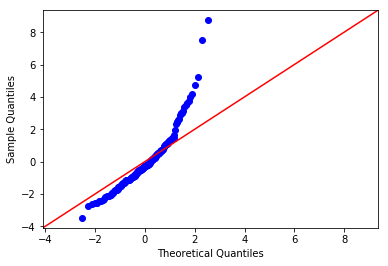

In [14]:
qq2=sm.qqplot(maxOLS_all.resid, line='45')

**There are a few variables with P|t| values which are high, indicative of high randomness. Let's test different P|t| thresholds for which to remove variables, rerun and model for each set of variables, and see what threshold might glean best results**

In [15]:
rsq_adj = 0
thresh = 0

goodp_str = ""
highp_var = []

maximum_all_str = max(dictionary, key=dictionary.get)    #this is the string of variables found in previous OLS run associated with mad adjusted R squared.
print(maximum_all_str)


for test_thresh in range(1, 100):   #loop through different P|t| thresholds ranging from 1 to 100.  Note floats are not allowed here 
  print(test_thresh)
  highp_var = [var for var in maxOLS_all.pvalues.keys() if maxOLS_all.pvalues[var]>=test_thresh*0.01]  #check P|t| for each variable against threshold and store in list
  
  testgoodp_str = maximum_all_str   #reset testgoodp_str 
    
  for var in highp_var:
    testgoodp_str = testgoodp_str.replace("+ " + var, "")   #  
     

 

  maxOLS_testgoodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + testgoodp_str,test_train_df[train_yrs_tt]).fit()
  print(testgoodp_str, maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
  #print(maxOLS_testgoodp.rsquared_adj)
  if maxOLS_testgoodp.rsquared_adj > rsq_adj:
      rsq_adj = maxOLS_testgoodp.rsquared_adj
      print(maxOLS_testgoodp.rsquared_adj, test_thresh*0.01)
      goodp_str = testgoodp_str
      thresh = test_thresh*0.01

    
print("\n best threshold is:" + str(thresh))
maxOLS_goodp = ols('CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in ~' + goodp_str,test_train_df[train_yrs_tt]).fit() 
print(maxOLS_goodp.summary())


KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC
1
KGJT_d250_200_dwpc+ LXV_Temperature_degC 0.052846571479557736 0.01
0.052846571479557736 0.01
2
KGJT_d250_200_dwpc+ LXV_Temperature_degC+ CMtn_Dewpoint_degC 0.07009946588604798 0.02
0.07009946588604798 0.02
3
KGJT_d250_200_dwpc+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ CMtn_Dewpoint_degC 0.09590825409163994 0.03
0.09590825409163994 0.03
4
KGJT_d250_200_dwpc+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ CMtn_Dewpoint_degC 0.09590825409163994 0.04
5
KGJT_d250_200_dwpc+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ CMtn_Dewpoint_degC 0.09590825409163994 0.05
6
KGJT_d250_200_dwpc+ LXV_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ CMtn_Dewpoint_degC 0.10098028239585899 0.06
0.10098028239585899 0.06
7
KGJT_d250_200_dwp

KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 0.142422209533154 0.4
41
KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 0.142422209533154 0.41000000000000003
42
KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 0.142422209533154 0.42
43
KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ 

KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 0.142422209533154 0.68
69
KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 0.142422209533154 0.6900000000000001
70
KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 0.142422209533154 0.7000000000000001
71
KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_

KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 0.142422209533154 0.96
97
KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 0.142422209533154 0.97
98
KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_height_m+ LXV_WindSpeed_mps+ CMtn_WindSpeed_mps+ KGJT_d700_400_tmpc+ LXV_Temperature_degC+ KGJT_200mb_tmpc+ KGJT_250mb_speed_kts+ KGJT_400mb_dwpc+ CMtn_Dewpoint_degC 0.142422209533154 0.98
99
KGJT_d250_200_dwpc+ CMtn_Temperature_degC+ KGJT_d700_200_speed_kts+ KGJT_d500_250_height_m+ KGJT_d400_300_

**No improvement to P|t| could be made**

## Try fit parameters with test dataset (2016 and 2017 data)

count    37.000000
mean      5.716216
std       2.605604
min       3.000000
25%       4.000000
50%       5.000000
75%       6.000000
max      14.000000
Name: CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in, dtype: float64
count    37.000000
mean      4.565241
std       0.797425
min       2.777427
25%       4.017178
50%       4.694673
75%       5.128105
max       6.104605
dtype: float64
37


Text(0.5,1,'Predicted vs Actual Snowfall Amounts')

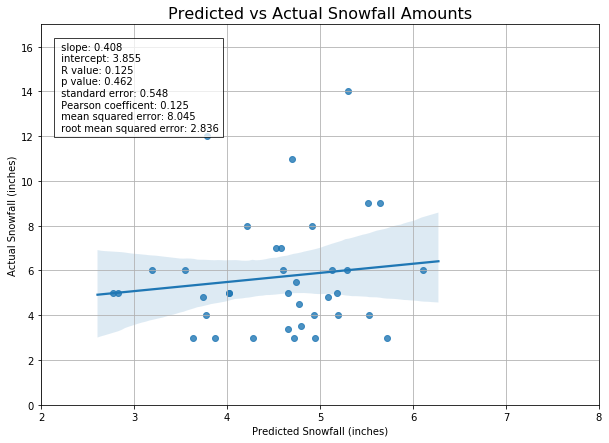

In [16]:
fig = plt.figure(figsize=(10,7))



#Define actual and predicted snowfall dataframes
##actual_snf = test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']  #      [test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3]
##predict = maxOLS_goodp.predict(test_train_df[test_yrs_tt]) #    [test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3])

#predict = maxOLS_all.predict(test_train_df[test_yrs_tt]) #    [test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3])
actual_snf = test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in'][test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3]
predict = maxOLS_goodp.predict(test_train_df[test_yrs_tt][test_train_df[test_yrs_tt]['CMtnSNTL_Upcoming12hrSNOWFALL_gte3_in']>=3])

print(actual_snf.describe())
print(predict.describe())


#Do linear regression and calcuate relevent stats

from scipy.stats import pearsonr, linregress
from sklearn.metrics import mean_squared_error


idx = np.isfinite(predict) & np.isfinite(actual_snf) 
print(len(idx))

#print(test_train_df[test_yrs_tt][test_train_df['CMtnSNTL_Past12hrSNOWFALL_in']>=3].describe())


## Do linear regression and calculate slope, intercept, r, p, std err
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(predict[idx], actual_snf[idx])
#Calculate mse and rmse
mse = mean_squared_error(actual_snf[idx].values,predict[idx].values)
rmse = np.sqrt(mse)
pearson1, pv = pearsonr(predict[idx], actual_snf[idx])

#plot and annotate
sns.regplot(predict[idx].values, actual_snf[idx].values)
bbox_props=dict(facecolor='red', alpha=0.75, fc = 'white')
plt.annotate(' slope: ' + str(round(slope1,3)) +
                 '\n intercept: ' + str(round(intercept1,3)) + 
                 '\n R value: ' + str(round(r_value1,3)) +  
                 '\n p value: ' + str(round(p_value1,3)) + 
                 '\n standard error: ' + str(round(std_err1,3)) +
                 '\n Pearson coefficent: ' + str(round(pearson1,3)) +
                 '\n mean squared error: ' + str(round(mse,3)) +
                 '\n root mean squared error: ' + str(round(rmse,3)), \
                 xy=(0.03, 0.72), xycoords='axes fraction', fontsize=10, bbox = bbox_props)

plt.xlabel('Predicted Snowfall (inches)')
plt.ylabel('Actual Snowfall (inches)')
plt.xlim([2,8])
plt.ylim([0,17])
plt.grid(True)
plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/pred_vs_act_UASFC_2014_noWD.png',bbox_inches='tight')
plt.title('Predicted vs Actual Snowfall Amounts', fontsize = 16)





[4.28034814 4.21194682 4.74372268 4.7191443  3.77260272 5.18797538
 3.74761416 4.02668101 4.5303461  4.69467288 4.93440059 5.71972822
 6.10460532 4.94180747 5.12810465 2.7774273  4.79519285 4.59985933
 3.55118408 3.6355707  4.77744563 4.90997437 4.65958137 2.82388026
 4.65640151 5.08355847 5.30493965 5.52381647 3.19086383 4.01717813
 4.5792764  5.28782358 3.78697225 5.1889613  3.86663672 5.64128834
 5.51239838]
[ 3.   8.   5.5  3.   4.   5.   4.8  5.   7.  11.   4.   3.   6.   3.
  6.   5.   3.5  6.   6.   3.   4.5  8.   5.   5.   3.4  4.8 14.   4.
  6.   5.   7.   6.  12.   4.   3.   9.   9. ]


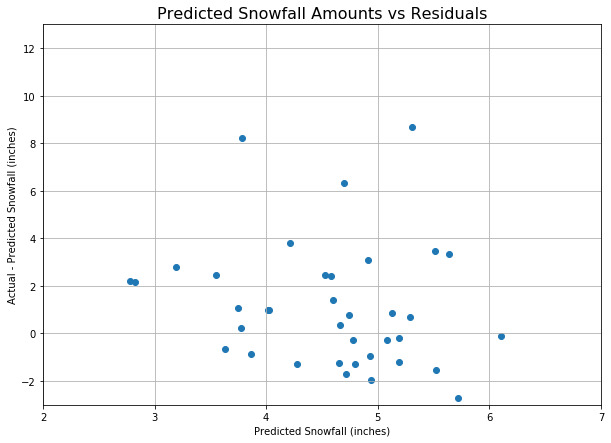

In [17]:
fig = plt.figure(figsize=(10,7))

plt.scatter(predict[idx].values, actual_snf[idx].values-predict[idx].values)
print(predict[idx].values)
print(actual_snf[idx].values)
#print(actual_snf[idx].values-predict[idx].values)

plt.ylabel('Actual - Predicted Snowfall (inches)')
plt.xlabel('Predicted Snowfall (inches)')
plt.xlim([2,7])
plt.ylim([-3,13])
plt.grid(True)
plt.title('Predicted Snowfall Amounts vs Residuals', fontsize = 16)

plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/resid_vs_pred_UASFC_2014_noWD.png',bbox_inches='tight')



Text(0.5,1,'Theoretical vs Sample Quantiles of Residuals')

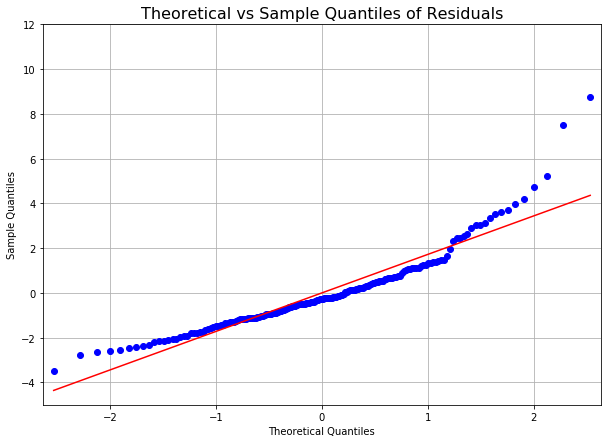

In [18]:
fig, ax = plt.subplots(figsize=(10, 7))
qq2=sm.qqplot( maxOLS_testgoodp.resid, line='r', ax = ax)

plt.ylim([-5,12])
plt.grid(True)
plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/qq_resid_UASFC_2014_noWD.png',bbox_inches='tight')
plt.title('Theoretical vs Sample Quantiles of Residuals', fontsize = 16)

Text(0.5,1,'Histogram of Residuals')

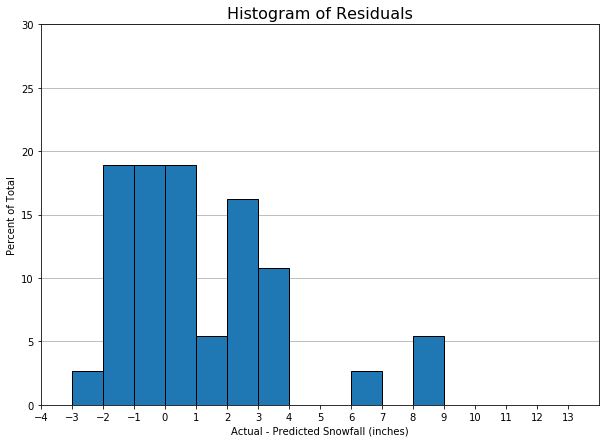

In [19]:

diff = actual_snf[idx].values-predict[idx].values
diff_df = pd.DataFrame(diff)
fig = plt.figure(figsize=(10, 7))
ax = plt.subplot(1,1,1)

#plt.hist(diff, bins = np.arange(-4,14,0.5), histtype = 'bar')
weights = np.ones_like(diff)/float(len(diff))
plt.hist(diff, histtype = 'bar', weights=weights*100, \
           bins = np.arange(-4,14,1), align = 'mid', edgecolor = 'black') 

plt.xlabel('Actual - Predicted Snowfall (inches)')
plt.ylabel('Percent of Total')
plt.xlim([-4,14])
#plt.ylim([0,10])
#plt.grid(True)

plt.xticks(np.arange(-4,14,1))
plt.yticks(np.arange(0,31,5))
ax.set_axisbelow(True)   #places gridlines behind bars
plt.grid(True, axis = 'y')
plt.title('')

plt.savefig('C:/Users/RAPP/Documents/Capstone/Report/figs/hist_actual_minus_pred_UASFC_2014_noWD.png',bbox_inches='tight')
plt.title('Histogram of Residuals', fontsize = 16)
